In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, date
from prefect.blocks.system import Secret
from catnip.fla_redshift import FLA_Redshift
from typing import Dict
from concurrent.futures import ThreadPoolExecutor
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from collections import Counter

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
def get_redshift_credentials() -> Dict:

    cred_dict = {
        "dbname": Secret.load("stellar-redshift-db-name").get(),
        "host": Secret.load("stellar-redshift-host").get(),
        "port": 5439,
        "user": Secret.load("stellar-redshift-user-name").get(),
        "password": Secret.load("stellar-redshift-password").get(),

        "aws_access_key_id": Secret.load("fla-s3-aws-access-key-id-east-1").get(),
        "aws_secret_access_key": Secret.load("fla-s3-aws-secret-access-key-east-1").get(),
        "bucket": Secret.load("fla-s3-bucket-name-east-1").get(),
        "subdirectory": "us-east-1",

        "verbose": False,
    }

    return cred_dict

with ThreadPoolExecutor(1) as pool:
    rs_creds = pool.submit(lambda: get_redshift_credentials()).result()

In [3]:
# q = """
# with seats as
#     (select
#         distinct seat_id, pc_one
#     from
#         custom.cth_manifest_2223),
# event_dates as
#     (select
#         event_date, tier, is_premier, original_six_plus_extra, abbreviation
#     from
#         custom.cth_game_descriptionsv  
#     where
#         season = '2023-24' and game_type = 1 and event_date = '2023-10-19'),
# transaction_dates as
#     (select
#          transaction_date
#      from
#          custom.cth_v_ticket_2324
#      where
#         date(event_datetime) >= date(transaction_date)),
# other as
#     (select
#         event_datetime, section, row, seat, transaction_date,
#         cast(section as varchar)+'-'+cast(row as varchar)+'-'+cast(seat as varchar) as seat_id, gross_revenue, ticket_type
#     from
#         custom.cth_v_ticket_2324),
# base as
#     (select
#         *
#     from
#         event_dates
#     cross join
#         seats
#     cross join
#         transaction_dates)
# select
#     base.event_date, base.transaction_date, tier, is_premier::int, datediff(day, date(other.transaction_date), date(base.event_date)) as days_out,
#     original_six_plus_extra, base.seat_id, abbreviation, pc_one,
#         CASE
#             WHEN pc_one in ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', '1', '2', '3', '4', '5', '6', '7', '8')
#             THEN 'Lowers'
#             WHEN pc_one in ('K', 'L', 'M') THEN 'Clubs'
#             WHEN pc_one in ('N', 'O', 'P', 'Q', 'R', 'S', 'T') THEN 'Uppers'
#             WHEN pc_one in ('U', 'V', 'W') THEN 'Suites'
#             WHEN pc_one in ('X') THEN 'Amerant'
#             WHEN pc_one in ('Y') THEN 'Loft'
#             WHEN pc_one in ('Z') THEN 'Corona'
#             ELSE 'unknown'
#             END AS location,
#     CASE
#         when gross_revenue > 0 then gross_revenue
#         else 0
#     end as block_purchase_price,
#     CASE
#         when ticket_type IS NOT NULL then ticket_type
#         else 'Not Sold'
#     end as ticket_type_final,
#     CASE
#         when ticket_type_final in ('Full', 'Annual Suites', 'Premier', 'Flex', 'Quarter', 'Sponsor', 'Trade') then 'Plans'
#         when ticket_type_final in ('Not Sold') then 'Not Sold'
#         else 'Nightly'
#     end as ticket_type_group
# from
#     base
# left join
#     other on date(base.event_date) = date(other.event_datetime) and base.seat_id = other.seat_id
# order by
#     base.event_date, base.seat_id
# """
# df_2324 = FLA_Redshift(**rs_creds).query_warehouse(sql_string=q)

In [27]:
q = """
select 
    event_date, tier, is_premier, original_six_plus_extra
from 
    custom.cth_game_descriptions
where 
    season = '2023-24'
"""
tier_df = FLA_Redshift(**rs_creds).query_warehouse(sql_string=q)

In [28]:
df_2324 = pd.read_csv("C:\\Users\\riffere\\Desktop\\emily_ticket_sales_model_data_final.csv")

In [29]:
#df_2324 = df_2324.sample(n = 15000)

In [30]:
df_2324 = df_2324.merge(tier_df, on = 'event_date', how = 'left')

In [31]:
df_2324['dow'] = [datetime.weekday(datetime.strptime(x, "%Y-%m-%d")) for x in df_2324['event_date']]
df_2324['tier_num'] = [5 if tier == 'A' else (4 if tier == 'B' else (3 if tier == 'C' else (2 if tier == 'D' else 1))) for tier in df_2324['tier']]
#df_2324['random'] = [x for x in (np.random.rand(len(df_2324),1)/2)]

pcs = sorted(df_2324['pc_one'].unique())
pc_dict = dict((value,count) for count, value in enumerate(pcs))
df_2324['pc_num'] = df_2324.apply(lambda row: pc_dict[row['pc_one']], axis = 1)
df_2324 = df_2324.sample(n=len(df_2324), random_state=1993)
df_2324 = df_2324.reset_index()

In [32]:
def run_model(df_test, df_train):

    #df_test_subset = df_test[(df_test['days_out'] == days_out) & (df_test['ticket_type_final'] == 'Not Sold')]

    X_test = df_test[['dow', 'tier_num', 'pc_num', 'is_premier', 'original_six_plus_extra','days_out']]
    y_test = df_test[['is_sold']]

    #df_train_subset = df_train[df_train['date_diff'] == days_out]

    X_train = df_train[['dow', 'tier_num', 'pc_num', 'is_premier', 'original_six_plus_extra','days_out']]
    y_train = df_train[['is_sold']]

    if len(X_test) > 0:
        ss = StandardScaler()
        x_train_scaled = ss.fit_transform(X_train)
        x_test_scaled = ss.fit_transform(X_test)

        clf = RandomForestClassifier(random_state = 1993)
        clf.fit(x_train_scaled, y_train)

        predicted_df = pd.DataFrame(data = clf.predict(x_test_scaled), columns = ['is_sold_predicted'])
        final_df = pd.concat([df_test, predicted_df], axis = 1)

        return final_df

In [9]:
# def run_model(df_test, df_train):

#     #df_test_subset = df_test[(df_test['days_out'] == days_out) & (df_test['ticket_type_final'] == 'Not Sold')]

#     X_test = df_test[['dow', 'tier_num', 'pc_num', 'is_premier', 'original_six_plus_extra','days_out']]
#     y_test = df_test[['ticket_type_group']]

#     #df_train_subset = df_train[df_train['date_diff'] == days_out]

#     X_train = df_train[['dow', 'tier_num', 'pc_num', 'is_premier', 'original_six_plus_extra','days_out']]
#     y_train = df_train[['ticket_type_group']]

#     if len(X_test) > 0:
#         ss = StandardScaler()
#         x_train_scaled = ss.fit_transform(X_train)
#         x_test_scaled = ss.fit_transform(X_test)

#         clf = RandomForestClassifier(random_state = 1993)
#         clf.fit(x_train_scaled, y_train)

#         predicted_df = pd.DataFrame(data = clf.predict_proba(x_test_scaled), columns = ['Nightly', 'Not Sold', 'Plans'])
#         final_df = pd.concat([df_test.reset_index(), predicted_df], axis = 1)

#         return df_test

c:\Users\riffere\Documents\pandas_party\venv\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.9708


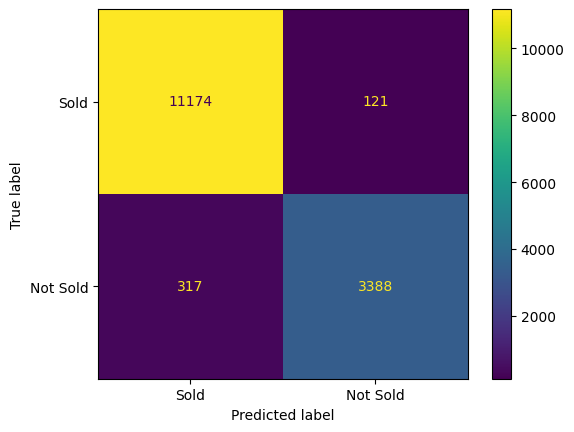

In [35]:
final_df = run_model(df_2324, df_2324)

cm = confusion_matrix(final_df['is_sold'], final_df['is_sold_predicted'])
print(accuracy_score(final_df['is_sold'],final_df['is_sold_predicted']))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sold','Not Sold'])
disp.plot()
plt.show()

In [19]:
# unique_dates = df_2324['event_date'].unique()
# today = str(date.today())
# final_df = pd.DataFrame()
# for event_date in unique_dates:
#     days_out = (datetime.strptime(today, '%Y-%m-%d') - datetime.strptime(event_date, '%Y-%m-%d')).days
#     #for i in range(1,days_out):
#     #    df = run_model(df_2324, df_2324, i)
#     #    final_df = pd.concat([final_df,df])
#     df = run_model(df_2324, df_2324, 42)
#     final_df = pd.concat([final_df,df])
# final_df

In [8]:
final_df['predicted'].value_counts()

predicted
Nightly    465
Plans      354
Name: count, dtype: int64